In [2]:
# Loading library and check datasets files and sizes
import numpy as np # linear algebra
import pandas as pd # data processing
import os
import gc
import matplotlib.pyplot as plt
import collections
%matplotlib inline

print("# File names")
for f in os.listdir("data/"):
    if 'zip' not in f:
        print(f.ljust(50) + str(round(os.path.getsize('data/' + f) / 1000000, 2)) + 'MB')

# File names
air_reserve.csv                                   5.83MB
air_store_info.csv                                0.07MB
air_visit_data.csv                                8.76MB
date_info.csv                                     0.01MB
hpg_reserve.csv                                   126.24MB
hpg_store_info.csv                                0.48MB
sample_submission.csv                             1.09MB
store_id_relation.csv                             0.01MB


In [3]:
# Load datasets
air_res = pd.read_csv('./data/air_reserve.csv')
air_sto = pd.read_csv('./data/air_store_info.csv')
air_visit = pd.read_csv('./data/air_visit_data.csv')
date_info = pd.read_csv('./data/date_info.csv')
hpg_res = pd.read_csv('./data/hpg_reserve.csv')
hpg_sto = pd.read_csv('./data/hpg_store_info.csv')
sample_sub = pd.read_csv('./data/sample_submission.csv')
sto_id = pd.read_csv('./data/store_id_relation.csv')

# Understanding Data

From the introduction of data files on Kaggle and the above list of data file sizes, we know there have two systems for store reservation, i.e., air and hpg. And the reservation volume from hpg is significantly larger than that from air. The two reservation systems also share some of the store information (store_id_relation.csv). Thus, we can combine the reservation data from the two systems. Besides, air_visit_data provides us the most direct data to interpret the relation of daily visitor numbers to a store. Thus, we firstly check the dataset contents in air_visit.

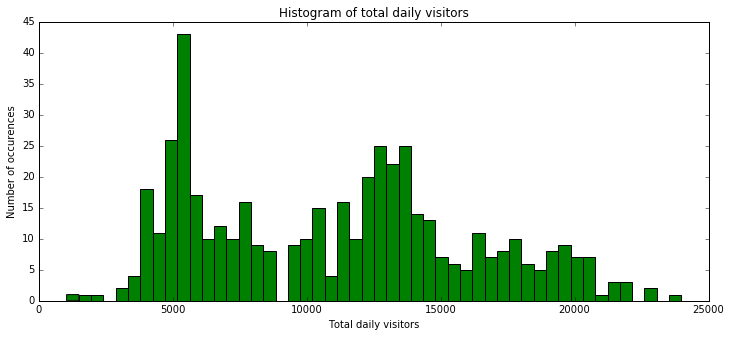

In [4]:
# check air_visit_data dataset contents
# distribution of total daily visitors
daily_visitors = air_visit.groupby('visit_date').sum()

plt.figure(figsize=(12, 5))
plt.hist(daily_visitors['visitors'], 50, normed=0, facecolor='green', alpha=1)
plt.title('Histogram of total daily visitors')
plt.xlabel('Total daily visitors')
plt.ylabel('Number of occurences')
print()

Looks like there has two peaks of daily visitor numbers. Why? Let's check it later.

C:\Users\hongliang\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


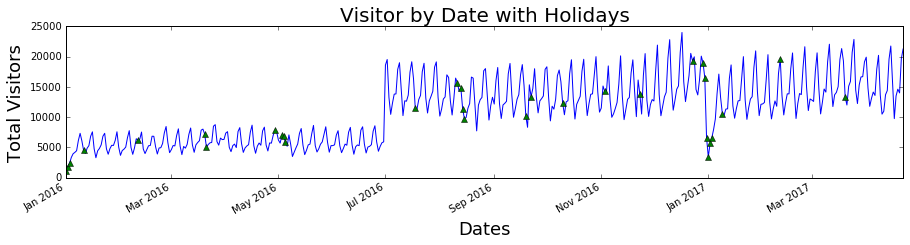

In [5]:
# Now let's see total daily visitors vs time

# Add holiday marker
date_info['holiday_mark'] = False
date_info['holiday_mark'].loc[date_info['holiday_flg'] == 1] = True
# training dates
num_dates = daily_visitors['visitors'].size

tmp_list = []
mark_list = []
for i in range(num_dates):
    tmp_list.append(daily_visitors['visitors'][i])
    mark_list.append(date_info['holiday_mark'][i])
# if lengths of all the related lists are the same, the 'visitor_date' in air_visit is continuous from '1/1/2016' to '4/22/2017'
# the plot also includes the holiday markers
if (air_visit['visit_date'].unique().size == num_dates) and (len(pd.date_range('1/1/2016', '4/22/2017')) == num_dates):
    vis_vs_time = pd.Series(tmp_list, index=pd.date_range('1/1/2016', '4/22/2017'))
    hol_markers = pd.Series(mark_list, index=pd.date_range('1/1/2016', '4/22/2017'))
    ts2 = vis_vs_time[hol_markers]
    
    fig, ax1 = plt.subplots(figsize = (15, 3))
    ax1.plot(vis_vs_time.index, vis_vs_time, ts2.index, ts2, 'g^')
    ax1.set_xlabel('Dates', fontsize=18)
    ax1.set_ylabel('Total Visitors', fontsize=18)
    ax1.set_title('Visitor by Date with Holidays', fontsize=20)
    fig.autofmt_xdate()

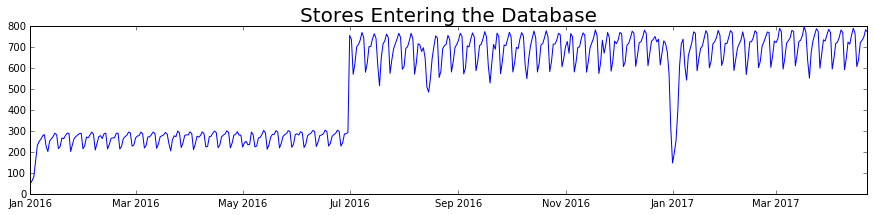

In [6]:
tmp_list2 = []
for i in range(num_dates):
    tmp_list2.append(air_visit.groupby('visit_date')['air_store_id'].unique()[i].size)

plt.figure(figsize=(15, 3))
plt.plot(vis_vs_time.index, tmp_list2)
plt.title('Stores Entering the Database', fontsize=20)

In [7]:
ave_vis_before070116 = sum(tmp_list[0:len(pd.date_range('1/1/2016', '6/30/2016'))])/(len(pd.date_range('1/1/2016', '6/30/2016')))
ave_vis_after070116 = sum(tmp_list[len(pd.date_range('1/1/2016', '6/30/2016')):])/len(pd.date_range('7/1/2016', '4/22/2017'))
print("The ratio between average visitor numbers before and after 7/1/2016 is " + str(round(ave_vis_after070116/ave_vis_before070116,2)) + "!")

ave_stor_before070116 = sum(tmp_list2[0:len(pd.date_range('1/1/2016', '6/30/2016'))])/(len(pd.date_range('1/1/2016', '6/30/2016')))
ave_stor_after070116 = sum(tmp_list2[len(pd.date_range('1/1/2016', '6/30/2016')):])/len(pd.date_range('7/1/2016', '4/22/2017'))
print("The ratio between average visiting store numbers before and after 7/1/2016 is " + str(round(ave_stor_after070116/ave_stor_before070116,2)) + "!")

print("They are consistent!!!")

The ratio between average visitor numbers before and after 7/1/2016 is 2.51!
The ratio between average visiting store numbers before and after 7/1/2016 is 2.63!
They are consistent!!!


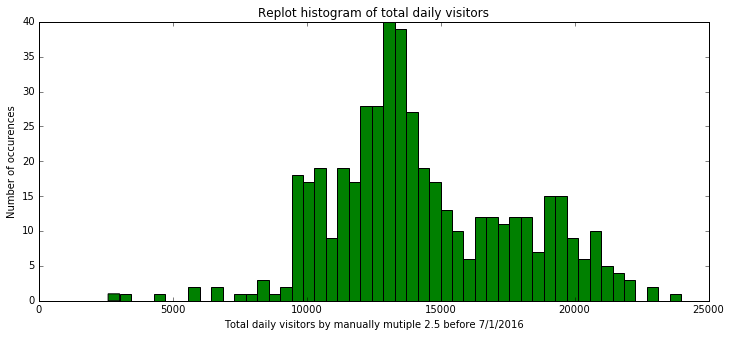

In [8]:
# replot the distribution of total daily visitors
daily_visitors2 = 2.5*(air_visit.groupby('visit_date').sum())
# recombined data
df = [daily_visitors2['visitors'][0:len(pd.date_range('1/1/2016', '6/30/2016'))], daily_visitors['visitors'][len(pd.date_range('1/1/2016', '7/1/2016')):]]
daily_visitors_com = pd.concat(df)

plt.figure(figsize=(12, 5))
plt.hist(daily_visitors_com, 50, normed=0, facecolor='green', alpha=1)
plt.title('Replot histogram of total daily visitors')
plt.xlabel('Total daily visitors by manually mutiple 2.5 before 7/1/2016')
plt.ylabel('Number of occurences')
print()

Summary of the above data visualization:
1. Visitor number on holidays is not special except around New Year Holidays (12/31-01/05), when the numbers decrease significantly.
2. There has a visitor jump at the beginning of Jul 2016. It is due to the increased stores entering the database. The average increase of total visitor numbers is consistent to the average increase of store numbers. Thus, such visitor jump will not affect the predicted daily visitor numbers of each store. Let's keep the data as it is.
3. The total daily visitors roughly follow normal distribution after manually modifying the visitor number before 7/1/2016. This just tells us the visitor distribution pattern. We will not modify the data for training and testing, since the final result is to predict daily visitors of each store not the total visitor numbers.

In [9]:
# add new column 'day_of_week' to air_visit dataset
air_visit['day_of_week'] = 'Sunday'
for i in range(7):
    tmp_day_week = date_info.groupby('day_of_week')['calendar_date'].unique().index[i]
    for j in date_info.groupby('day_of_week')['calendar_date'].unique()[i]:
        if j not in air_visit['visit_date'].unique():
            break
        else:
            air_visit['day_of_week'].loc[air_visit['visit_date'] == j] = tmp_day_week
air_visit.head()

C:\Users\hongliang\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,air_store_id,visit_date,visitors,day_of_week
0,air_ba937bf13d40fb24,2016-01-13,25,Wednesday
1,air_ba937bf13d40fb24,2016-01-14,32,Thursday
2,air_ba937bf13d40fb24,2016-01-15,29,Friday
3,air_ba937bf13d40fb24,2016-01-16,22,Saturday
4,air_ba937bf13d40fb24,2016-01-18,6,Monday


In [10]:
# summary of visitors to day of week
air_visit.groupby('day_of_week')['visitors'].agg([np.sum, np.mean, np.std, np.size])

# top 3 days having the largest average visitor numbers are Saturday, Sunday and Friday. Not surprising.
# However, the total visitor numbers on Sunday is significantly smaller than the other two. Possibly, 
# a number of stores are not open to public on Sunday (see the 'size' value).
# The figure below confirms out statement.

,sum,mean,std,size
day_of_week,,,,
Friday,931008,23.072737,16.575974,40351
Monday,544202,17.177009,14.105566,31682
Saturday,1033128,26.313688,18.934794,39262
Sunday,715986,23.873362,20.131047,29991
Thursday,718987,18.922702,14.606176,37996
Tuesday,636462,17.672137,14.611202,36015
Wednesday,707880,19.230121,15.378986,36811


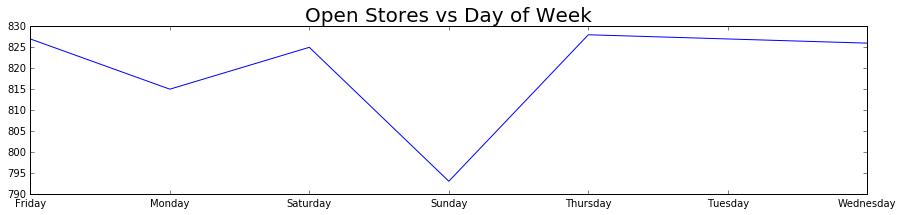

In [11]:
tmp_list3 = []
tmp_index = [x for x in range(7)]
for i in range(7):
    tmp_list3.append(air_visit.groupby('day_of_week')['air_store_id'].unique()[i].size)

plt.figure(figsize=(15, 3))
plt.plot(tmp_index, tmp_list3)
plt.xticks(tmp_index, air_visit.groupby('day_of_week')['air_store_id'].unique().index)
plt.title('Open Stores vs Day of Week', fontsize=20)

# Reservations

In [12]:
air_res.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92378 entries, 0 to 92377
Data columns (total 4 columns):
air_store_id        92378 non-null object
visit_datetime      92378 non-null object
reserve_datetime    92378 non-null object
reserve_visitors    92378 non-null int64
dtypes: int64(1), object(3)
memory usage: 2.8+ MB


In [13]:
air_res.tail()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
92373,air_db4b38ebe7a7ceff,2017-05-29 18:00:00,2017-04-17 19:00:00,6
92374,air_1033310359ceeac1,2017-05-30 23:00:00,2017-04-19 17:00:00,8
92375,air_877f79706adbfb06,2017-05-31 20:00:00,2017-04-12 23:00:00,3
92376,air_900d755ebd2f7bbd,2017-05-31 20:00:00,2017-04-19 16:00:00,10
92377,air_3cad29d1a23209d2,2017-05-31 21:00:00,2017-04-22 10:00:00,3


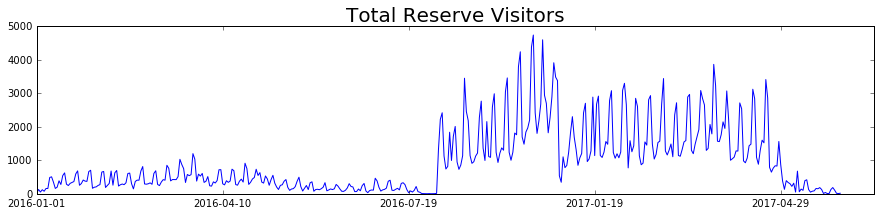

In [14]:
air_res['visit_date'] = air_res['visit_datetime'].str.split(' ').str.get(0)

daily_res_visitors = air_res.groupby('visit_date').sum()

num_res_dates = daily_res_visitors['reserve_visitors'].size

tmp_res_list = []
index_res_tmp = [x for x in range(num_res_dates)]
for i in range(num_res_dates):
    tmp_res_list.append(daily_res_visitors['reserve_visitors'][i])

plt.figure(figsize=(15, 3))
plt.plot(index_res_tmp, tmp_res_list)
#plt.xticks(index_res_tmp, daily_res_visitors['reserve_visitors'].index)
plt.xticks([index_res_tmp[i] for i in range(0,num_res_dates,100)], [daily_res_visitors['reserve_visitors'].index[i] for i in range(0,num_res_dates,100)])
#plt.locator_params(axis='x', nbins=10)
plt.title('Total Reserve Visitors', fontsize=20)


1. Air_reserve misses most reserve_visiting_dates in Aug, Sep and Oct 2016.
2. So few stores before July 2016.
3. Air_reserve has 314 different stores, which is close to the average visiting store numbers in air_visit_data before 7/1/2016. Is there any connection?
4. Why the numbers jump after 10/27/2016?

In [15]:
# air_stores that appear before 7/1/2016 in air_visit_data
tmp_list4 = []
for i in range(len(pd.date_range('1/1/2016', '6/30/2016'))):
    tmp_list4 += [element for element in air_visit.groupby('visit_date')['air_store_id'].unique()[i]]
    
print("The air_stores that appear before 7/1/2016 in air_visit_data is " + str(len(set(tmp_list4))) + ".")
print("While, air_reserve has 314 different stores.")
print("However, only " + str(len(set(tmp_list4) & set(air_res['air_store_id'].unique()))) + " stores appear in the above two lists.")
print("So, no strong connection between the two lists.")

The air_stores that appear before 7/1/2016 in air_visit_data is 316.
While, air_reserve has 314 different stores.
However, only 123 stores appear in the above two lists.
So, no strong connection between the two lists.


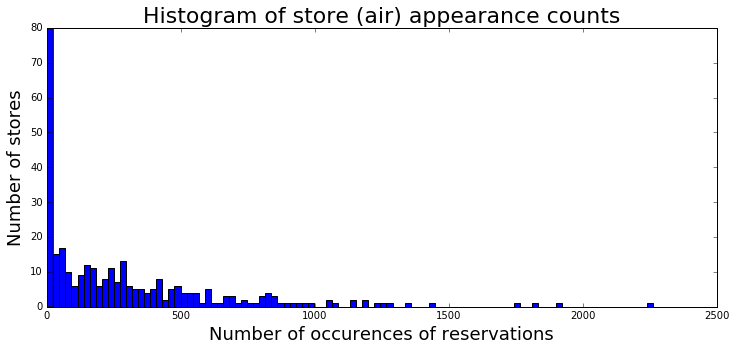

In [16]:
# Histogram of revervation times
plt.figure(figsize=(12, 5))
plt.hist(air_res['air_store_id'].value_counts(), bins=100)
plt.title('Histogram of store (air) appearance counts', fontsize=22)
plt.xlabel('Number of occurences of reservations', fontsize=18)
plt.ylabel('Number of stores', fontsize=18)
print()

The air_resesrvation data is sparse, while the hpg_reservation data gives more statistically reasonable distribution. The much larger database of hpg_reservation is one reason. But it cannot answer why there has a large number of stores have only been reserved for 1 or 2 times within 16 months (This is quite strange). So it is not a good idea to train and predict using air_reservation dataset without any featureing process. 
1. Have a better understanding on why we have such behavior in air_reservation. The small air_store numbers before 07/01/2016 in the database has an effect? Visitors prefer going to air_stores without reservation or they reserve via hpg? 
2. Since we need to predict air store visitors, we need a more reliable air_reservation dataset. Expand air_reservation database by connecting hpg_reservation via sto_id? 

In [17]:
hpg_res.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000320 entries, 0 to 2000319
Data columns (total 4 columns):
hpg_store_id        object
visit_datetime      object
reserve_datetime    object
reserve_visitors    int64
dtypes: int64(1), object(3)
memory usage: 61.0+ MB


In [18]:
hpg_res.head()

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13


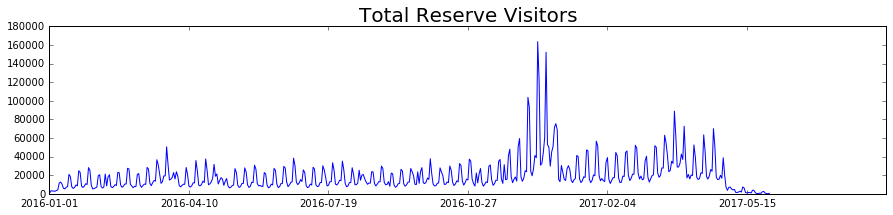

In [19]:
hpg_res['visit_date'] = hpg_res['visit_datetime'].str.split(' ').str.get(0)

daily_hpgres_visitors = hpg_res.groupby('visit_date').sum()

num_hpgres_dates = daily_hpgres_visitors['reserve_visitors'].size

tmp_hpgres_list = []
index_hpgres_tmp = [x for x in range(num_hpgres_dates)]
for i in range(num_hpgres_dates):
    tmp_hpgres_list.append(daily_hpgres_visitors['reserve_visitors'][i])

plt.figure(figsize=(15, 3))
plt.plot(index_hpgres_tmp, tmp_hpgres_list)
#plt.xticks(index_res_tmp, daily_res_visitors['reserve_visitors'].index)
plt.xticks([index_hpgres_tmp[i] for i in range(0,num_hpgres_dates,100)], [daily_hpgres_visitors['reserve_visitors'].index[i] for i in range(0,num_hpgres_dates,100)])
#plt.locator_params(axis='x', nbins=10)
plt.title('Total Reserve Visitors', fontsize=20)

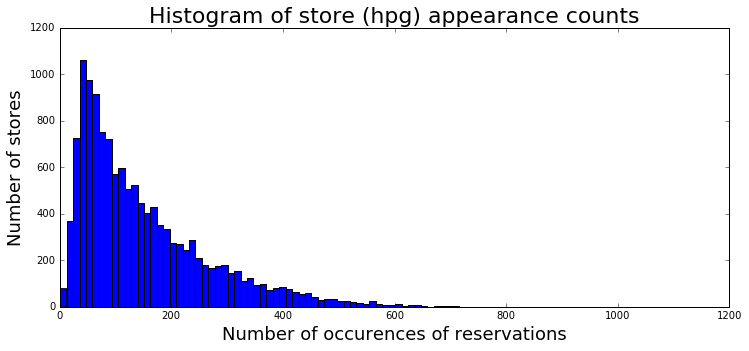

In [20]:
# Histogram of revervation times
plt.figure(figsize=(12, 5))
plt.hist(hpg_res['hpg_store_id'].value_counts(), bins=100)
plt.title('Histogram of store (hpg) appearance counts', fontsize=22)
plt.xlabel('Number of occurences of reservations', fontsize=18)
plt.ylabel('Number of stores', fontsize=18)
print()

In [21]:
# total stores in each dataset
store_air_res = air_res['air_store_id'].unique().size
store_air_visit = air_visit['air_store_id'].unique().size
store_air_sto = air_sto['air_store_id'].size
store_hpg_res = hpg_res['hpg_store_id'].unique().size
store_hpg_sto = hpg_sto['hpg_store_id'].unique().size
shared_store = len(sto_id)
store_submission = sample_sub.id.str.split('_').str.get(1).unique().size

print("The total stores in air_reserve.csv, air_store_info.csv and air_visit_data.csv are " + str(store_air_res) + ", " + str(store_air_sto) + " and " + str(store_air_visit) + ".")
print("The total stores in hpg_reserve.csv and hpg_store_info.csv are " + str(store_hpg_res) + " and " + str(store_hpg_sto) + ".")
print("The stores appear in both air and hpg databases are " + str(shared_store) + ".")
print("The stores appear in the submission file are " + str(store_submission) + ".")

# How many shared stores do not appear in air databases?
print("The stores in air_store_info and air_visit_data are same? " + str(collections.Counter(air_sto['air_store_id'].unique()) == collections.Counter(air_visit['air_store_id'].unique())))
print("The stores in store_id_relation is a subset of air_store_info? " + str(set(sto_id['air_store_id'].unique()) < set(air_sto['air_store_id'].unique())))
print("The stores in store_id_relation is a subset of air_visit_data? " + str(set(sto_id['air_store_id'].unique()) < set(air_visit['air_store_id'].unique())))
print("The stores in store_id_relation is a subset of air_reserve? " + str(set(sto_id['air_store_id'].unique()) < set(air_res['air_store_id'].unique())))

# Does all air stores in the submission file appear in air_sotre_info and air_visit_data?
print("The stores in sample_submission is a subset of air_store_info or air_visit_data? " + str(set((sample_sub.id.str.split('_').str.get(0)+'_'+sample_sub.id.str.split('_').str.get(1)).unique()) < set(air_sto['air_store_id'].unique())))


The total stores in air_reserve.csv, air_store_info.csv and air_visit_data.csv are 314, 829 and 829.
The total stores in hpg_reserve.csv and hpg_store_info.csv are 13325 and 4690.
The stores appear in both air and hpg databases are 150.
The stores appear in the submission file are 821.
The stores in air_store_info and air_visit_data are same? True
The stores in store_id_relation is a subset of air_store_info? True
The stores in store_id_relation is a subset of air_visit_data? True
The stores in store_id_relation is a subset of air_reserve? False
The stores in sample_submission is a subset of air_store_info or air_visit_data? True


# Shared store visitors in air and hpg

In [22]:
print("The stores appear in both air and hpg databases are " + str(shared_store) + ".")
print("Only " + str(len(set(sto_id['air_store_id'].unique()) & set(tmp_list4))) + " of the all 150 shared stores appear before 7/1/2016 in air_visit_data.")
print("On the other hand, there have " + str(len(set(sto_id['air_store_id'].unique()) & set(air_res['air_store_id'].unique()))) + " of the all 150 shared stores appear in air_reservation dataset.")
print("Therefore, we can expand air_reservation dataset by inserting the related 131 stores from hpg_reservation.")
print("We can also compare the variation of total reservation_visitors of the shared stores to reservation_visiting_date in both air and hpg datasets. For the sake of understanding why there has a jump of visiting numbers around 7/1/2016.")

The stores appear in both air and hpg databases are 150.
Only 55 of the all 150 shared stores appear before 7/1/2016 in air_visit_data.
On the other hand, there have 131 of the all 150 shared stores appear in air_reservation dataset.
Therefore, we can expand air_reservation dataset by inserting the related 131 stores from hpg_reservation.
We can also compare the variation of total reservation_visitors of the shared stores to reservation_visiting_date in both air and hpg datasets. For the sake of understanding why there has a jump of visiting numbers around 7/1/2016.


In [59]:
sto_id.head()

,air_store_id,hpg_store_id,total_air_res_visitors,total_hpg_res_visitors,total_visitors
0,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a,0,0,8181
1,air_a24bf50c3e90d583,hpg_c34b496d0305a809,0,0,6517
2,air_c7f78b4f3cba33ff,hpg_cd8ae0d9bbd58ff9,0,0,5202
3,air_947eb2cae4f3e8f2,hpg_de24ea49dc25d6b8,0,0,6751
4,air_965b2e0cf4119003,hpg_653238a84804d8e7,0,0,4256


In [60]:
# expanding sto_id
air_res_gb_store = air_res.groupby('air_store_id')
hpg_res_gb_store = hpg_res.groupby('hpg_store_id')
air_visit_gb_store = air_visit.groupby('air_store_id')

sto_id['total_air_res_visitors'] = 0
sto_id['total_hpg_res_visitors'] = 0
sto_id['total_visitors'] = 0

In [61]:
for i in range(store_air_res):
    if air_res_gb_store.sum()['reserve_visitors'].index[i] in set(sto_id['air_store_id']):
        for j in range(len(sto_id)):
            if air_res_gb_store.sum()['reserve_visitors'].index[i] == sto_id['air_store_id'][j]:
                sto_id['total_air_res_visitors'][j] = air_res_gb_store.sum()['reserve_visitors'][i]
        #print(str(air_res_gb_store.sum()['reserve_visitors'].index[i]) + "  " + str(air_res_gb_store.sum()['reserve_visitors'][i]))

C:\Users\hongliang\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [62]:
for i in range(store_hpg_res):
    if hpg_res_gb_store.sum()['reserve_visitors'].index[i] in set(sto_id['hpg_store_id']):
        for j in range(len(sto_id)):
            if hpg_res_gb_store.sum()['reserve_visitors'].index[i] == sto_id['hpg_store_id'][j]:
                sto_id['total_hpg_res_visitors'][j] = hpg_res_gb_store.sum()['reserve_visitors'][i]
        #print(str(hpg_res_gb_store.sum()['reserve_visitors'].index[i]) + "  " + str(hpg_res_gb_store.sum()['reserve_visitors'][i]))

C:\Users\hongliang\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [63]:
for i in range(air_visit['air_store_id'].unique().size):
    for j in range(len(sto_id)):
        if air_visit_gb_store.sum()['visitors'].index[i] == sto_id['air_store_id'][j]:
            sto_id['total_visitors'][j] = air_visit_gb_store.sum()['visitors'][i]

C:\Users\hongliang\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [64]:
sto_id.head()

,air_store_id,hpg_store_id,total_air_res_visitors,total_hpg_res_visitors,total_visitors
0,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a,202,2047,8181
1,air_a24bf50c3e90d583,hpg_c34b496d0305a809,1586,1658,6517
2,air_c7f78b4f3cba33ff,hpg_cd8ae0d9bbd58ff9,1285,253,5202
3,air_947eb2cae4f3e8f2,hpg_de24ea49dc25d6b8,0,1529,6751
4,air_965b2e0cf4119003,hpg_653238a84804d8e7,2412,462,4256


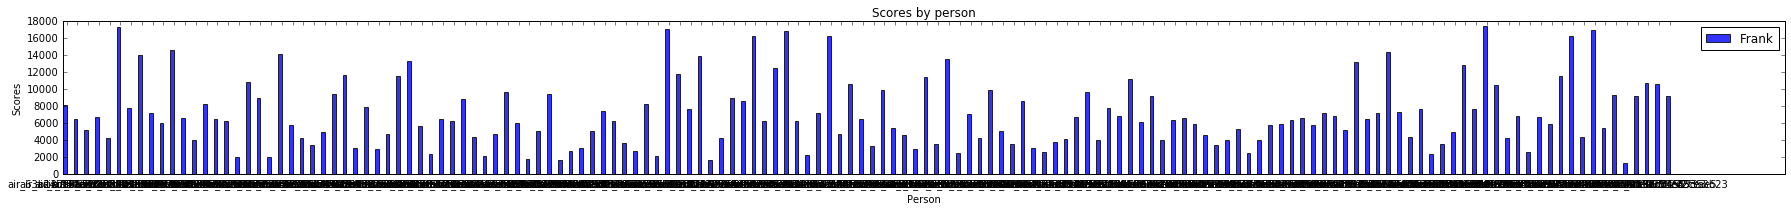

In [74]:
n_groups = len(sto_id)
plot_total_visitors = sto_id['total_visitors']
 
# create plot
plt.figure(figsize=(25, 3))
#fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
 
rects1 = plt.bar(index, plot_total_visitors, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Frank')

plt.xlabel('Person')
plt.ylabel('Scores')
plt.title('Scores by person')
plt.xticks(index + bar_width, sto_id['air_store_id'])
plt.legend()
 
plt.tight_layout()
plt.show()